# Exploring Hamiltonian Monte Carlo

##### Keywords: hamiltonian monte carlo, energy, NUTS, leapfrog, canonical distribution, microcanonical distribution, transition distribution, marginal energy distribution, data augmentation, classical mechanics, detailed balance, statistical mechanics

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from IPython.core.display import Image

import pymc3 as pm

# Introduction 

A lot of HMC's recent appreciation as an MCMC method is due to [Neal](https://arxiv.org/pdf/1206.1901.pdf), and we'll follow him and [Betancourt](https://arxiv.org/abs/1701.02434) heavily here. All the signature Maroon diagrams are from Betancourt's review paper.

## Looking for the perfect MCMC?

The problem with MH is that is sensitive to the step size, Gibbs we need to know how to draw from the conditionals. What we want is the ability to adjust the step size but at the same time preserving the properties of MCMC, namely being able to sample the whole space and at the same time converge to the target distribution. We also would like to have no burnin, no autocorrelation, guarantee mixing and convergence very fast and no tunable parameters (and a pony). 


In other words, we'd like to explore the typical-set surface smoothly. To do this we must first characterize the surface, something we can do via a gradient. To do this we must identify the equation of the typical set surface so that we can find the gradient which is perpendicular to the surface. And once we do that, we are not done, as the gradient points towards regions of higher density (modes) from the surface of the typical set.

To do this imagine a sliver $dP = p(q)dq$ thats in the typical set. If $dq$ (we are using $q$ instead of $x$) is small enough, then we can consider the typical set as a collection of foliates $\{q_i\}$ each of constant probability density  $p(q)=c_i$ where $c_i$ is a constant. Thus there are n such foliates, or "orbits", or level sets. Now we know that the gradient is perpendicular to such level-sets and we can use it to characterize these sets.

## Mechanics to the rescue

We can make our usual connection to the energy of a physical system by tentatively identifying the energy $E = - log(p(q))$. This is what we did to find distributions in Metropolis and the inverse $p(q) = e^{-E(q)/T}$ the minima of functions in simulated annealing. There we proposed a move using a proposal distribution, creating a random walk.

We dont want to do that here, preferring something that will move us smoothly along a level set. We use our newly acquired knowledge of data-augmentation and gibbs-sampling from an augmented distribution instead.

But first let us make a change of purpose and notation. Lets write now the potential energy as:

$$V(q) = - log\, p(q)$$

such that

$$p(q) = e^{-V(q)}.$$

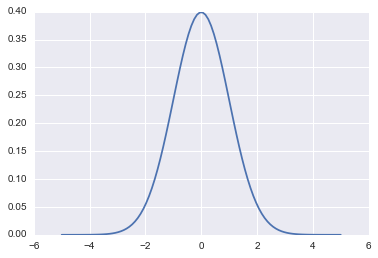

In [31]:
fun = lambda q: sp.stats.norm.pdf(q) 

qq = np.linspace(-5,5,100)
plt.plot(qq, fun(qq))

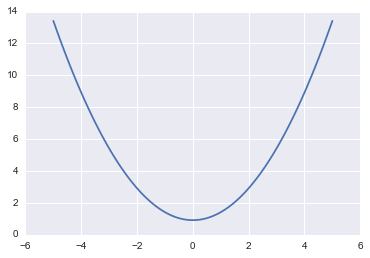

In [33]:
V = lambda q: -np.log(fun(q))
plt.plot(qq, V(qq))

The basic idea is to add a **momentum** variable $p$ for each $q$ in our probability density, adding a kinetic energy term to the potential energy to create a total energy, and thus creating a joint pdf $p(p,q)$. 

How would this work? And why momentum? Lets think about a rocket (or a satellite with thrusters it can fire) in orbit around the earth

![](images/rocketorbit.png)

If this rocket had no velocity, it would simply fall down to the earth because it would not be able to counterbalance earth's gravitational potential (the equivalent of the energy we formulated above and have used in simulated annealing). On the other hand, if it had too much velocity, it would escape earth's gravity and take off to mars or similar.

If we add just the right amount of momentum, it will exactly counterbalance the gravitational force, and the satellite will continue to move in its orbit. And this is an orbit of minimum energy (and therefore constant energy, since a system at minumum energy wont lift from it unless kicked(perhaps stochastically) to do so). Thus the satellite will move exactly along a level-curve of the energy level, in a direction exactly perpendicular to the gradient. Such motion is called **conservative**, as it conserves energy. In mechanics, the conserving of energy is related to the time-independence and thus time irreversibility of motion: is there is no *explicit* dependence on time in the equations of motion (there always is implicit dependence as positions and momenta depend on time), energy is conserved.

## Data Augmentation

Recall that the basic idea behind Data Augmentation is to resolve difficulty in simulate from $p(x)$ using the traditional methods by constructing a joint pdf such that:

$$ \int p(x,y)\, dy = p(x)  $$

and simulating from the associated conditional pdfs, $p(x|y)$ and $p(y|x)$ is easy.

The DA algorithm is based on this joint pdf, and we *marginalize* over the **augmenting variable** $y$ to obtain samples for $p(x)$.

The simplest form of DA algorithm takes the following form:

1. Draw $Y\sim P_{Y|X}(.|x)$ and call the observed value y
2. Draw $X_{n+1} \sim P_{X|Y}(.|y)$

After disregarding the $Y_i$ in our samples in making a $X$ histogram, we have  samples $X_i \sim P(x)$.

To achieve our goal we introduce a new variable as we did for DA and Slice Sampling we now call $p$. As we explained in DA the new joint distribution 

$$p(q) = \int p(q,p) \, dp $$

An easy way to achieve this is if $p(q,p)=p(q)p(p \vert q)$. And since we can choose our joint distribution as we like, we choose (the reasons will be obvious soon). 

$$ p(q,p) = e^{-V(q)-K(q,p)} = e^{-V(q)} e^{-p^2/2m}$$

Where $m$ is just a constant thus  $p(p)$ is  Gaussian. The kinetic energy if $p$ is the momentum is $K(q, p)=p^2/2m$.  This kinetic energy $K(p,q)$ has a mass parameter $m(q)$(one can consider generalizations of the kinetic energy term from this version we have from introductory physics).

The choice of a kinetic energy term then is the choice of a conditional probability distribution over the "augmented" momentum which ensures that

$$\int dp p(p, q) = \int dp p(p \vert q) p(q) = p(q) \int p(p \vert q) dp = p(q).$$


Thus the key to moving a sampler along a probability level curve is to give the sampler momentum and thus kinetic energy via the augmented momemtum variable. In other words, we must carry out an augmentation with an additional momentum which leaves the energy **Hamiltonian**

$$H(p, q) = \frac{p^2}{2m} +  V(q) = E_i,$$

and thus:

$$H(p,q) = -log(p(p,q)) = -log p(p \vert q) - log p(q)$$

with $E_i$ constants (constant energies) for each level-set foliate and where the **potential energy** $V(q) = -log(p(q))$ replaces the energy term we had earlier in simulated annealing. 

**Thus it is critical to realize that we are now looking at level curve foliates of $p(p,q)$, not those of $p(q)$**. Our real aim is to explore the latter. This joint distribution is called the **canonical distribution**

With a quadratic in $p$ and if $V(q) = \frac{1}{2}q^2$ our distribution is gaussian and the level sets are ellipses of constant energy, as illustrated below, in a space called **phase space**, which is constructed by plotting the co-ordinates against the momenta: that is, it is just the space in which our augmented joint-distribution lives.

![](images/levelsets.png)

##  Hamiltonian Mechanics

The game now is to sample from this two-N-dimensional distribution and marginalize over the momenta to get the distribution from the $q$. To carry out this sampling, we'll use the physics equations of motion in the **Hamiltonian Formalism** (thus leading to the name Hamiltonian Monte Carlo) to "glide" over a level set.   Given a Hamiltonian H, the Hamiltonian equations of motion are as follows:

$$
\begin{eqnarray}
\frac{dp}{dt}  &=& -\frac {\partial H}{\partial q} \\
\frac{dq}{dt}  &=& \frac {\partial H}{\partial p} 
\end{eqnarray}
$$

If we have

$$H=p^2/2m + V(q)$$

then $\frac{dp}{dt} = -\frac {\partial H}{\partial q} = -\frac {\partial V}{\partial q} = Force$ is newton's law, and the other equation sats that velocity is momentum divided by mass.

### An example

Here is an example of a harmonic oscillator with mass 1 and spring-constant 1

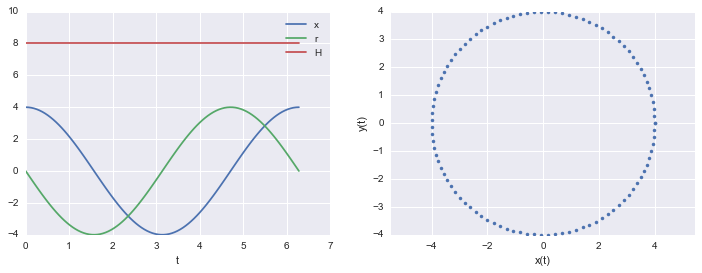

min and max of H:  8.0 8.0


In [6]:
q_t = lambda t: 4. * np.cos(t)
p_t = lambda t: -4. * np.sin(t)
H_x_r_t = lambda t: q_t(t)**2/2. + p_t(t)**2/2.

t = np.linspace(0,2*np.pi,100)

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(t, q_t(t), label='q')
plt.plot(t, p_t(t), label='p')
plt.plot(t, H_x_r_t(t), label='H')
plt.xlabel('t')
plt.legend()

plt.subplot(1,2,2)
plt.plot(q_t(t), p_t(t), '.')
plt.axis('equal')
plt.xlabel('q(t)')
plt.ylabel('p(t)')

plt.show()

print("min and max of H: ", np.min( H_x_r_t(t)), np.max( H_x_r_t(t)))

### The Hamiltonian is conserved

Notice that in the example above the Hamiltonian is conserved. While the $q$ amd $p$ have time dependencies, the $H$ does not.

If the Hamiltonian H doesn't have a functional dependence on time we see that 

$$ \frac{dH}{dt} = \sum_i \left[\frac {\partial H}{\partial q_i}\frac{dq_i}{dt} + \frac {\partial H}{\partial p_i}\frac{dp_i}{dt} \right] + \frac{\partial H}{\partial t} $$

Notice that I have explicitly indexed the co-ordinates and momenta to reflect the dimensionality of the prolem.

Substituting in the Hamiltonian equations of motion we can see:
$$ \frac{dH}{dt} = \sum_i \left[\frac {\partial H}{\partial q_i}\frac {\partial H}{\partial p_i} + (\frac {\partial H}{\partial p_i})(-\frac {\partial H}{\partial q_i}) \right] + \frac{\partial H}{\partial t} $$


So as long as the Hamiltonian $ H(\{q_i, p_i\}, t)$ depends only on $ \{q_i, p_i \} $ then $\frac{\partial H}{\partial t} = 0$ and

$$ \frac{dH}{dt} = 0\ $$

and thus $ H(t + \Delta t) = H(t) \, \forall t $.

This time independence is crucial to reversibility: we cannot pick a direction of time in which this system is actually being run.

### Reversibility

Consider a transformation $T_s$ from $(q,p) \to (q',p')$ where the primed quantities are just the variables at a "later" time $t' = t + s$. This mapping is 1-1 and thus has an inverse $T_{-s}$. This can be obtained by simply negating time in Hamilton's equations:

$$
\begin{eqnarray}
\frac{dp}{d(-t)}  &=& -\frac {\partial H}{\partial q} \\
\frac{dq}{d(-t)}  &=& \frac {\partial H}{\partial p} 
\end{eqnarray}
$$

This changes the equations of motion and would not be kosher, but we can
preserve the equation, by merely transforming $p \to -p$ and then 

$$
\begin{eqnarray}
\frac{d(-p)}{d(-t)}  &=& -\frac {\partial H}{\partial q} \\
\frac{dq}{d(-t)}  &=& \frac {\partial H}{\partial (-p)} 
\end{eqnarray}
$$

and we have the old equations back. Notice that the momentum transformation does not change the Hamiltonian as long as the kinetic energy is symmetric in $p$.

In other words this is what we need is this: to reverse $T_{s}$, flip the momentum, run Hamiltonian equations backwords in time until you get back to the original position and momentum in phase space at time t, and then flip the momentum again so it is pointing in the right direction (otherwise you would be going the wrong direction on re-running time forward...that is u want to make the tranformation which preserved the Hamiltonian equations above, twice.).

In our oscillator example above, $T_{-s}$ is simply a rotation by $s$ radians counterclockwise in phase space, undoing the clockwise rotation created by $T_s$, and then fliiping the direction of rotation again.

This is like in the superman movie! It will be critical in crafting a reversible Metropolis-Hastings proposal soon.

### Volume in phase space is conserved

Not only does no-explicit-time dynamics conserve the Hamiltonian, it also conserves a volume element in phase space. One can see this by If the determinant of the Jacobian of this transformation is 1, the volume is preserved.

The transformation $T_{s}$ for small change $s = \delta$ can be written as:

$$ T_{\delta} = \left( \begin{array}{c} q \\ p\end{array} \right) + \delta \left( \begin{array}{c} \frac{dq}{dt} \\ \frac{dp}{dt}\end{array} \right)  + O(\delta^2)$$

The jacobian of this transformation is:
$$
\left [
\begin{array}{c}
 1 + \delta \frac{\partial^2H}{\partial q\partial p} & \delta \frac{\partial^2H}{\partial p^2} \\
\delta \frac{\partial^2H}{\partial q^2} &  1 - \delta \frac{\partial^2H}{\partial p\partial q}
\end{array}
\right ]
$$

and thus the determinant is 

$$ 1 +  O(\delta^2).$$

Since we can compose the time transformation $s$ out of many such data, out Hamiltonian is volume preserving!

Thus as our system evolves, any contraction or expansion in position space must be compensated by a respective expansion or compression in momentum space.

As a result of this, the momenta we augment our distribution with must be **dual** to our pdf's parameters, transforming in the opposite way so that phase space volumes are invariant.

### The microcanonical distribution

We have expanded our pdf's parameter space by auxillary momenta. We have lift our target distribution in $q$ space to a joint probability distribution on phase space called the **canonical** distribution. In this phase space, we can explore the joint typical set by integrating Hamiltonian equations for a time.

Since we will consider time-implicit Hamiltonians, these flows will be volume preserving and reversible, and indeed stick to a level surface of energy.

Indeed we are traveling along constant $E$ or $p(p,q)$ foliates. This allows us to consider a related distribution to the canonical distribution, the **microcanonical distribution** (the first term in the product below). The canonical distribution can be written as a product of this microcanonical distribution and a **marginal energy distribution**:

$$p(q,p) = p(\theta_E \vert E) p(E)$$

where $\theta_E$ indexes the position on the level set: ie a co-ordinate for example along the ellipses in our diagram above.

The microcanonical distribution thus gives us the states for a given energy (or joint probability) while the marginal tells us the probability of a given level set in the typical set itself.

This decomposition of the problem tells us how to explore the entire typical set. We integrate Hamilton's equations for a while to explore the microcanonical distribution on a given level set.

## Stochasticity


But this then leaves us with the problem of having to go from one level-set to another: after all, we wish to explore the entire typical set. We thus need to stochastically explore the marginal energy distribution to go from one level-set to the other.

### Sampling the momentum

The idea for this once again comes from our mechanical satellite analog. Think of a rocket in a partivcular orbit firing its thrusters or letting momentum slip. It can achieve a different orbit.

Thus the solution to exploring the marginal distribution is simple..after exploring a given level set for a while, we resample the momentum, and off to another level-set we go, as illustrated below:

![](images/momresample.png)

Let $p(E \vert q)$ as the transition distribution of energies induced by a momentum resampling using $p(p \vert q) = - log\, K(p,q)$ at a given position $q$. Our efficiency of this stochastic exploration over level sets then depends on how narrow this induced distribution is with respect to the marginal energy distribution:

![](images/lsetexp.png)

If the transition distribution is narrow compared to the marginal energy distribution, then the random walk amongst level sets will proceed slowly. But if it matches the marginal energy distribution, we will generate nearly independent samples from the marginal energy distribution very efficiently.

Thus we will draw $p$ from a distribution that is determined by the distribution of momentum, i.e. $p \sim  N(0,\sqrt{M})$ for example, and attempt to explore the level sets.

## Tuning

It should be clear now that HMC needs to be tuned in at-least two ways:

- what is our choice of kinetic energy and how does this impact the stochastic exploration of the marginal distribution
- how long shall we integrate along a certain level set


### Choice of Kinetic Energy

In theory we can choose any Kinetic Energy function K(p) that we deem useful.  The ideal kinetic energy would interact with the target distribution to make microcanonical exploration as easy and uniform as possible and marginal exploration well matched by the transition distribution.

In practice we often use

$$K(p) = p'M^{-1}p $$

so that $K(p) = \sum_i\frac{p_i^2}{2m_i} $ and M is diagonal square matrix with elements $ 1/m_i $. This would allow us to particularize to various parameters.

This is a euclidean-gaussian choice: euclidean as it corresponds to a euclidean norm on the co-ordinate space and gaussian as the conditional distribution it induces is Gaussian. Gaussian choices perform well in higher dimensions as marginal energy distributions become a convolution of more and more parameters and a kind of central-limit theorem holds.

If one were to set the inverse mass matrix to the covariance of the target distribution then one would maximally decorrelate the target distribution. This can be seen thus: apply the transformation $p \to \sqrt{M^{-1}}p$ which simplifies the kinetic energy but transforms the potential via $q \to \sqrt{M}q$ due to the duality and volume preservation of $q,p$ phase space. Then you are effectively dividing $q$ by the squareoot of its distributions covariance and carrying out our decorrelation. 

We can do this by computing a target covariance in a warm-up (this is not burn-in) phase of our sampler and then setting the kinetic energy appropriately to make an optimized chain.


### Choice of integration times

Choosing a kinetic energy defines the shape of the level sets. Now the game is to glide along any one of these. How long should we do it? If we do it too short, we are not taking advantage of the coherent Hamiltonian updates and are back to our drunk random walk. If we do it too long, the topological compactness of these level sets in well defined problems will mean we revisit old points in phase space, yielding slower convergence.

What we need to do is to find the point at which the orbital expectations converge to the spatial expectations..a sort of ergodicity. Integrating beyond this regime brings diminishing returns.

This time can be represented with two parameters, $L$, the number of iterations for which we run the Hamiltonian dynamics, and $\epsilon$ which is the (small) length of time each iteration is run. We say iterations as to solve Hamiltonian differential equations we will need to carry out a numerical solution of these equations with a small time-grid size. Then the total integration time is $L \times \epsilon$. These are parameters we need to play with, for this and other reasons (see below).

But in general, no single optimal integration time will hold...this depends on which orbit in which level set we are. In general, for a distribution more heavy tailed than a Gaussian, as we move to higher energy level sets in the tails, we will need more time to integrate over there (this can be shown analytically in 1-D$). Thus if we used a static integration time everywhere, the tails might be very poorly explored (and presumably more of the typical set is in the tails of these distributuions than for thin tailed ones.

Thus in general we will want to identify the integration time dynamically. This is the idea behind the No U-Turn Sampler (NUTS) which is the default in both pymc3 and Stan: the basic idea is that when the Hamiltonian flows starts to double back on itself and retrace its steps, we resample momentum again.

## Simulating Hamiltonian Systems:  Discretization

Unfortunately we can't simulate Hamiltonian systems exactly and we have to rely on discretization!  What does that mean?  Well in the derivations above, we assumed that we could solve the differential equations in question exactly.  Since we're going to be sampling from our Hamiltonian dynamics we need to discretize our systems in to small timesteps of size $ \epsilon $.  

There are a number of discretization methods available for simulating dynamics systems.  It turns out that all of them aren't equally useful.  Some of the properties of the Let's start with the simplest, Euler discretization.  In all of our discretization examples we'll make the following assumptions:

* the Hamiltonian has the form H(q, p) = U(q)+K(p)
* K(p) = $p'M^{-1}p $ so that $K(p) = \sum_i\frac{p_i^2}{2m_i} $ and M is square with diagonal elements $ 1/m_i $

Let's start with the most basic discretization, Euler's method.

### Euler Discretization

Euler discretization involves directly updating the momentum and position at each time step.  The algorithm is as follows:

* $p_i(t + \epsilon) = p_i(t) - \epsilon \frac{\partial U}{\partial q_i}\mid_{q(t)} $
* $q_i(t + \epsilon) = q_i(t) + \epsilon \frac{p_i(t)}{m_i} $

See code and plot below for harmonic oscillator, $ H = U(q) + K(p) = \frac{q^2}{2} + \frac{p^2}{2m} $.  Notice that the volume is not preserved as the  trajectory we plot for the harmonic oscillator, which should be an elipse, diverges to infinity and the Hamiltonian is not conserved as we'd expect it to be.  Something is wrong with this discretization.  



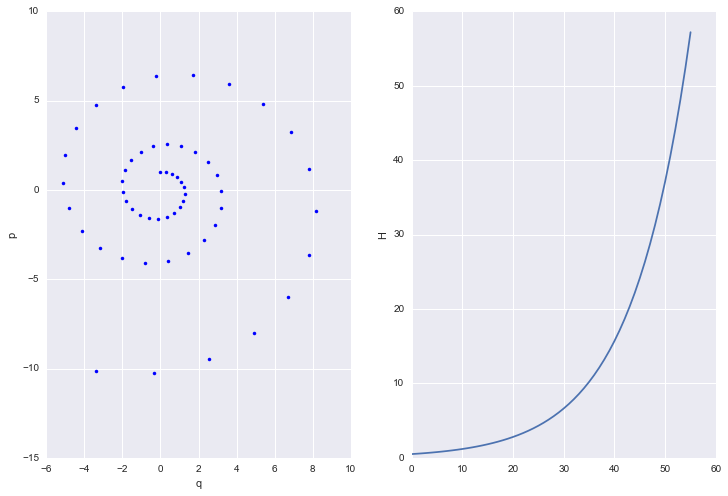

In [8]:
U = lambda q: q**2/2
K = lambda p:  (p**2)/2
dUdq= lambda q: q

def euler(p0, q0, L, epsilon):
    
    ps = [p0]
    qs = [q0]
    
    pprev = p0
    qprev = q0
    


    # alternate full steps for position and momentum
    for i in range(L):
        p = pprev - epsilon*dUdq(qprev)
        ps.append(p)
        q = qprev + epsilon*pprev
        qs.append(q)
        
        pprev = p
        qprev = q


    
    return (ps, qs)


eps,eqs = euler(1,0, 55, .3)
h = [U(q) + K(p) for q, p in zip(eqs, eps)]

plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.plot(eqs,eps, 'b.')
plt.xlabel('q')
plt.ylabel('p')
plt.subplot(1,2,2)
plt.plot(h)
plt.ylabel('H')

Most ODE solvers, like the one we just wrote, suffer from drift:

![](images/nummodeerr.png)

As we solve longer, error adds coherently, and our trajectory diverges from the true trajectory. This is because our discrete transformations like the Euler one above, do not preserve volume elements: the determinant of the Jacobian is larger than 1. The critical reason behind this is that we update both $p$ and $q$ simultaneously, accumulating error fast.

If you think about the Jacobian, then the diagonal terms are 1. But if you update both $p$ and $q$ at once, the off-diagonals are non-zero for small but finite $\epsilon$ (in other words u cant make $\epsilon \to 0$). Thus volume is not preserved.

What we want are **symplectic** integrators, which preserve phase space volume elements.

### Being symplectic: the Leapfrog method

Any method that has only *shear* transforms: ie something that changes only one thing at a time, will work. The **leapfrog** method is one such idea, involving stage-wise updating the momentum and position.  The algorithm is as follows:

* $p_i(t + \frac{\epsilon}{2}) = p_i(t) - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}\mid_{q(t)} $
* $q_i(t + \epsilon) = q_i(t) + \epsilon \frac{p_i(t+\frac{\epsilon}{2})}{m_i} $
* $p_i(t + \epsilon) = p_i(t+\frac{\epsilon}{2}) - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}\mid_{q(t+ \epsilon)} $

If we do this repeatedly, the first and last steps can be combined as you can see in the code below.

Notice that  volume is preserved and the trajectory is very stable.  In addition the discretization is reversible.  The leapfrog method (named because updating momentum and position leapfrog each other) is a symplectic discretization.  

min and max of leapfrog H:  7.6190477193 8.42105060531


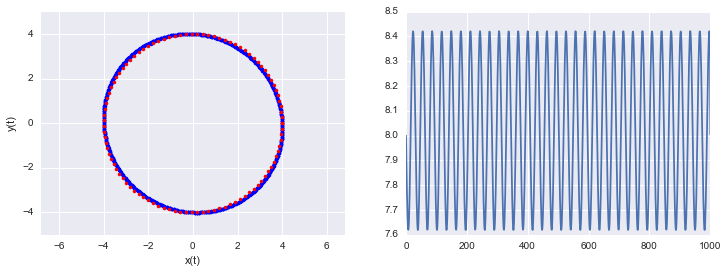

In [27]:
U = lambda q: (q)**2/2.
K = lambda p:  (p**2)/2.
dUdq= lambda q: q

def leapfrog(p0, q0, L, epsilon):
    # keep all the epsilon steps
    ps = [p0]
    qs = [q0]
    
    # starting position
    p = p0
    q = q0
    
    # Make a half step for momentum at the beginning
    p = p - epsilon*dUdq(q)/2.0

    # alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon*p
        qs.append(q)
        if (i != L-1):
            p = p - epsilon*dUdq(q)
            ps.append(p)

    #make a half step at the end
    p = p - epsilon*dUdq(q)/2.
    ps.append(p)

    return (ps, qs)



lps,lqs = leapfrog(4.,0., 1000, .1 )
h = [U(q) + K(p) for q, p in zip(lqs, lps)]

print("min and max of leapfrog H: ", np.min(h), np.max(h))

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(lqs,lps, 'b.')
plt.plot(x_t(t), r_t(t), 'r.')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(h)

plt.show()

One thing to note, see the diagram and code above, is that even though the discretization is symplectic it (like the Euler modification) doesn't preserve the Hamiltonian perfectly.  That's because of the approximation errors incumbant in discretization.  The error is very stable and the value of the Hamiltonian at each step oscillates around the true value.  

Because of this exact reversibility is lost. There is no reason to sweat though, superman to the rescue! When we sample from the potential in our HMC, we will use the acceptance probability to balance out the error in H.

### The Acceptance Probability

At the beginning of each sampling step we choose a new $p$ and our current $q$ and then run the Leapfrog algorithm for $L$ steps of size $ \epsilon $. The new $q_L$ and $p_L$ at the end of our Leapfrog steps is our new proposed values, with our proposal being

$$Q(q', p' \vert q, p) = \delta(q' - q_L) \delta (p' - p_L).$$

In other words, only propose something which gives us the integration sanctioned values..deterministic!

This would seam to be the end of the story, but remember that even our symplectic integrator has errors. Errors make the Hamiltonian flow irreversible. In other words we can only propose states going forwards in time: the proposal probability for the time-reversed transition is 0 and the acceptance ratio undefined.

But we know how to make the Hamiltonian transition reversible! Superman to the rescue. We augment the numerical integration with a momentum flip so that we now consider the transition:

$$(q,p) \to (q_L, -p_L)$$

with proposal:

$$Q(q', p' \vert q, p) = \delta(q' - q_L) \delta (p' + p_L).$$

This leads us to accept with probability 

$$A = \min[1, \frac{p(q_L, -p_L)\delta(q_L -q_L)\delta(-p_L + p_L)}{p(q,p)\delta(q-q)\delta(p-p)}] = \min[1, \frac{p(q_L, -p_L)}{p(q,p)}]$$

and thus:

$$A= \min[1, \exp(-U(q_L)+U(q)-K(p_L)+K(p)] $$

This is exactly the kind of acceptance ratio we have seen in simulated annealing and metropolis, and stems from our definition of the joint(canonical) distribution.

But the critical thing with HMC is that our **time evolution is on a level set**. So our acceptance probability is always close to 1, and we have a very efficient sampler. (You might have thought you could pick up a sample after each leapfrog update since it is coherent evolution of Hamiltonian equations, but then you would have to do a momentum reversal and acceptance comparision many many times).

The momentum reversal could be left out if you are not within a more complex sampling scheme like HMC within gibbs since you will be resampling anyways. But if you are updating both a discrete parameter and a continuous parameter, you will want to reverse the sign so that you are using the correct $p$ when sampling from the conditionals.

![](images/reversemom.png)

In general we'll want to sum over all such points in the orbit, since we want time averages to represent a sample from the microcanonical distribution.

## The HMC Algorithm

Now that we have the tools in place, let's describe the HMC algorithm.  We're going to assume as above a Kinetic Energy $ K(p) = \frac{p^{\top}M^{-1}p}{2}  $.  The algorithm is as follows

* for i=1:N_samples
    1. Draw $  p \sim N(0,M) $
    2. Set $ q_{c} = q^{(i)} $ where the subscript $c$ stands for current
    3. $ p_c = p $
    4. Update momentum before going into LeapFrog stage: $ p^* = p_c - \frac{\epsilon * \nabla U(q_c)}{2} $  
    5. LeapFrog to get new proposals. For j=1:L
        * $ q^{*} = q^{*} + \epsilon  p $
        * if not the last step, $ p = p - \epsilon  \nabla U(q) $
    6. Complete leapfrog: $ p = p - \frac{\epsilon  \nabla U(q)}{2} $
    7. $ p^{*}= -p $
    8. $ U_c = U(q_c), \,\,\, K_c = \frac{p_c^{\top}M^{-1}p_c}{2} $
    9. $ U^{*} = U(q^*), \,\,\, K^{*} = \frac{p^{\top*}M^{-1}p^*}{2} $
    10. $ r \sim \rm{Unif}(0,1) $
    11. if $ r < e^{(U_{c}-U^{*}+K_{c}-K^{*})} $  
       * accept $q_i = q^*$
       * otherwise reject
       

### A simple implementation

We implement the HMC algorithm below with a gaussian Kinetic energy

In [42]:
#constants

def HMC(U,K,dUdq,N,q_0, p_0, epsilon=0.01, L=100):
    p_mu=0.
    p_sig=1.
    
    current_q = q_0
    current_p = p_0
    
    H = np.zeros(N)
    qall = np.zeros(N)
    accept=0
    for j in range(N):
    
        q = current_q
        p = current_p
        
        #draw a new p
        p = np.random.normal(p_mu, p_sig)
        
        current_p=p
        
        # leap frog
        
        # Make a half step for momentum at the beginning
        p = p - epsilon*dUdq(q)/2.0
        
        
        # alternate full steps for position and momentum
        for i in range(L):
            q = q + epsilon*p
            if (i != L-1):
                p = p - epsilon*dUdq(q)
    
        #make a half step at the end
        p = p - epsilon*dUdq(q)/2.

        # negate the momentum
        p= -p;
        current_U = U(current_q)
        current_K = K(current_p)

        proposed_U = U(q)
        proposed_K = K(p)
        A=np.exp( current_U-proposed_U+current_K-proposed_K)
    
        # accept/reject
        if np.random.rand() < A:
            current_q = q
            qall[j]=q
            accept+=1
        else:
            qall[j] = current_q
        
        H[j] = U(current_q)+K(current_p)
    print("accept=",accept/np.double(N))
    return H, qall

In [43]:

# functions
U = lambda q: q**2/2.
K = lambda p:  (p**2)/2.
dUdq= lambda q: q



accept= 1.0


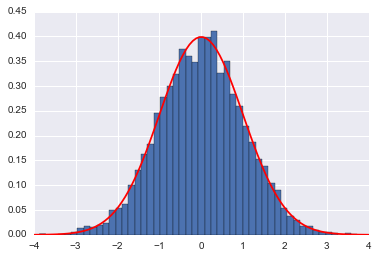

In [45]:
H, qall= HMC(U=U,K=K,dUdq=dUdq,N=10000,q_0=0, p_0=-4, epsilon=0.01, L=200)
plt.hist(qall, bins=50, normed=True)
x = np.linspace(-4,4,100)
plt.plot(x, sp.stats.norm.pdf(x),'r')
plt.show()

We compare it to a MH sampler with the same number of steps

In [46]:
def MH_simple(p, n, sig, x0):
    x_prev = x0
    x=[]
    k=1
    i=0
    while i<n:
        x_star = np.random.normal(x_prev, sig)
        P_star = p(x_star)
        P_prev = p(x_prev)
        U =  np.random.uniform()
        
        A =  P_star/P_prev
        if U < A:
            x.append(x_star)
            i = i + 1
            x_prev = x_star
            k +=1
        else :
            x.append(x_prev)
            x_prev = x[i]  
            i = i + 1
            
    print("accept=",k/np.double(n))
    return x

accept= 0.3002


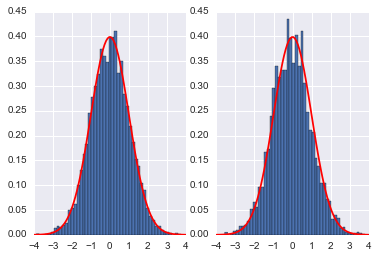

In [47]:
samples_mh = MH_simple(p=P, n=10000, sig=4.0, x0=0)

plt.subplot(1,2,1)
plt.hist(qall, bins=50, normed=True)
x = np.linspace(-4,4,100)
plt.plot(x, sp.stats.norm.pdf(x),'r')

plt.subplot(1,2,2)
plt.hist(samples_mh, bins=50, normed=True)
x = np.linspace(-4,4,100)
plt.plot(x, sp.stats.norm.pdf(x),'r')
plt.show()

Here we see that the MH acceptance ration is much lower and the correlation much higher!

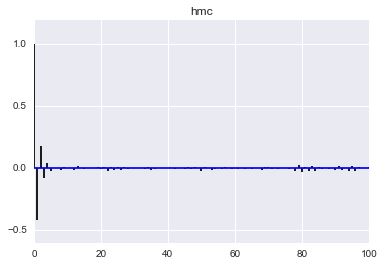

In [54]:
def corrplot(trace,  maxlags=100):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
corrplot(qall)
plt.title('hmc');

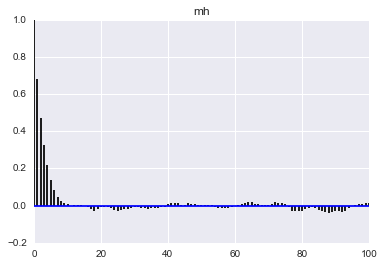

In [55]:
corrplot(samples_mh)
plt.title('mh');